# Librerias

In [34]:
!pip install optuna

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# Dataset

## Importacion

In [4]:
DATASET="Dry-Bean-Dataset.csv"
df_raw = pd.read_csv(DATASET)

## Valores Nulos


In [5]:
df_raw.isna().sum()

Area               0
Perimeter          0
MajorAxisLength    0
MinorAxisLength    0
Eccentricity       0
ConvexArea         0
EquivDiameter      0
Extent             0
Solidity           0
Compactness        0
ShapeFactor1       0
ShapeFactor2       0
ShapeFactor3       0
ShapeFactor4       0
Class              0
dtype: int64

## Dataset

In [6]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13611 entries, 0 to 13610
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             13611 non-null  int64  
 1   Perimeter        13611 non-null  float64
 2   MajorAxisLength  13611 non-null  float64
 3   MinorAxisLength  13611 non-null  float64
 4   Eccentricity     13611 non-null  float64
 5   ConvexArea       13611 non-null  int64  
 6   EquivDiameter    13611 non-null  float64
 7   Extent           13611 non-null  float64
 8   Solidity         13611 non-null  float64
 9   Compactness      13611 non-null  float64
 10  ShapeFactor1     13611 non-null  float64
 11  ShapeFactor2     13611 non-null  float64
 12  ShapeFactor3     13611 non-null  float64
 13  ShapeFactor4     13611 non-null  float64
 14  Class            13611 non-null  object 
dtypes: float64(12), int64(2), object(1)
memory usage: 1.6+ MB


In [7]:
df_raw

,Area,Perimeter,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,0.549812,28715,190.141097,0.763923,0.988856,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,0.411785,29172,191.272750,0.783968,0.984986,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,0.562727,29690,193.410904,0.778113,0.989559,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,0.498616,30724,195.467062,0.782681,0.976696,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,0.333680,30417,195.896503,0.773098,0.990893,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13606,42097,759.696,288.721612,185.944705,0.765002,42508,231.515799,0.714574,0.990331,0.801865,0.006858,0.001749,0.642988,0.998385,DERMASON
13607,42101,757.499,281.576392,190.713136,0.735702,42494,231.526798,0.799943,0.990752,0.822252,0.006688,0.001886,0.676099,0.998219,DERMASON
13608,42139,759.321,281.539928,191.187979,0.734065,42569,231.631261,0.729932,0.989899,0.822730,0.006681,0.001888,0.676884,0.996767,DERMASON
13609,42147,763.779,283.382636,190.275731,0.741055,42667,231.653248,0.705389,0.987813,0.817457,0.006724,0.001852,0.668237,0.995222,DERMASON


## Caracteristicas

<p> Además, se requiere que el alumno calcule y agregue al conjunto de datos las siguientes características <p>

* Aspect ratio (K): Relación entre la longitud del eje mayor (L) y la longitud del eje menor (l) .
* Roundness (R): Se debe calcular utilizando la fórmula (4piA)/(P^2).

In [8]:
df_raw["AspectRatio"] = df_raw['MajorAxisLength'] / df_raw['MinorAxisLength']
df_raw["Roundness"] = (4 * np.pi * df_raw['Area']) / (df_raw['Perimeter']**2)

## Distribuciones

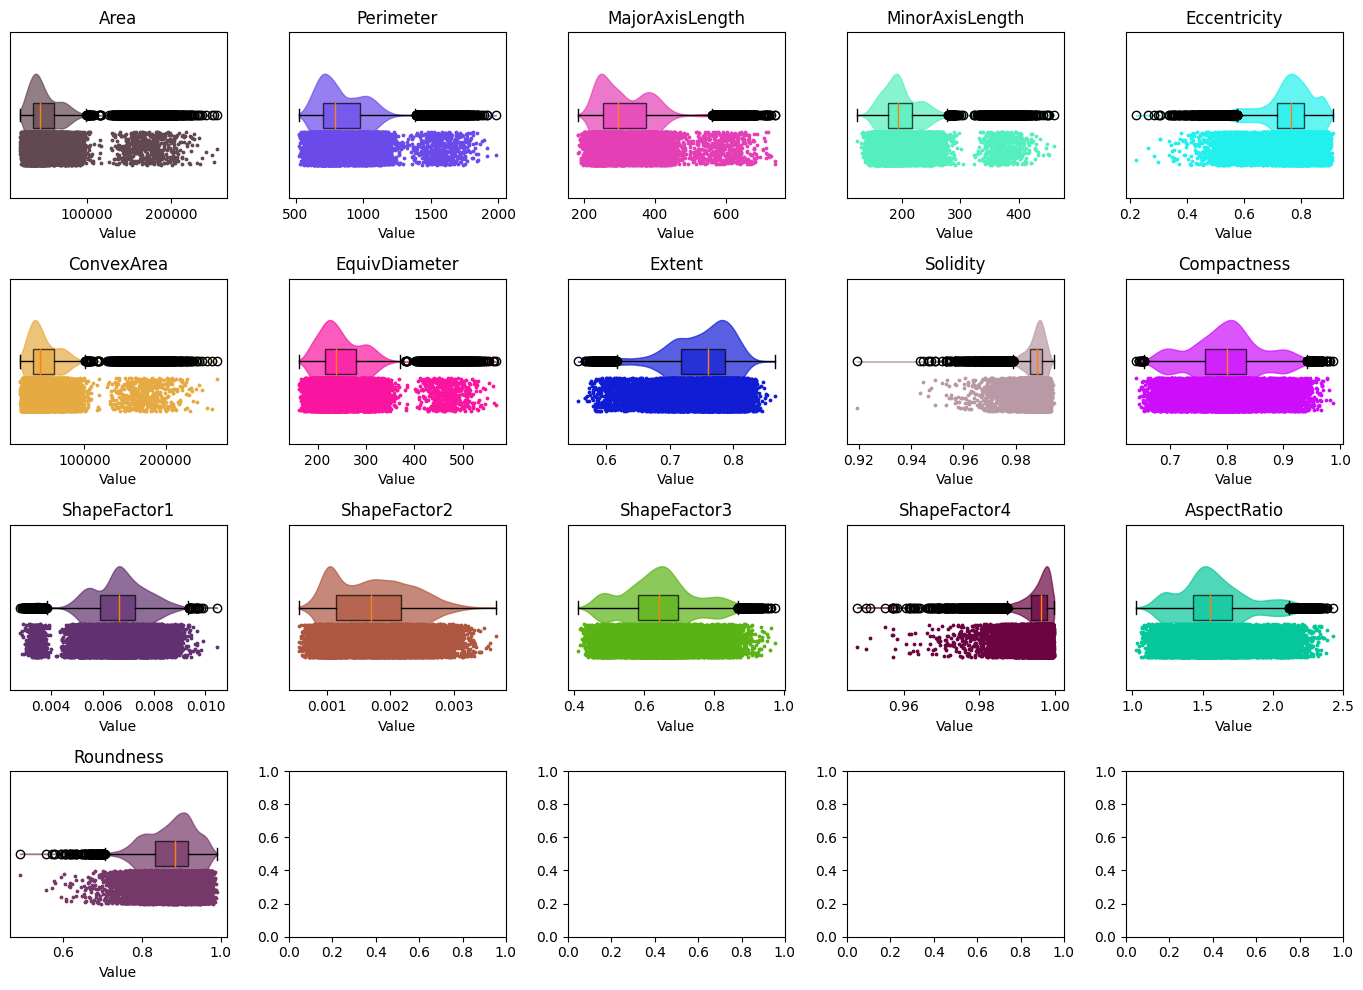

<Figure size 640x480 with 0 Axes>

In [9]:
def plot_boxplot(
    df,
    cols: list[str]=[],
    figsize: tuple = (18, 12),
    max_cols: int=6,
    scatter:bool=True,
    violin:bool= True,
    violin_args: dict = {},
    boxplot_args: dict = {}):

    default_violin_args = {
        "points": 500,
        "showmeans": False,
        "showextrema": False,
        "showmedians":False,
        "vert":False
    }

    default_boxplot_args = {
        "patch_artist": True,
        "vert":False
    }

    violin_args = {**default_violin_args, **violin_args}
    boxplot_args = {**default_boxplot_args, **boxplot_args}

    cols = cols if cols else list(df.columns)

    colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
        for i in range(len(cols))]

    n_rows = int(len(cols)/max_cols) + (len(cols)%max_cols>0)
    n_cols = max_cols

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize)

    plt.figure()

    for idx, column in enumerate(cols):
        ax = axes[idx // n_cols, idx % n_cols]

        bp = ax.boxplot(df[column], **boxplot_args)
        bp['boxes'][0].set_facecolor(colors[idx])
        bp['boxes'][0].set_alpha(0.7)

        if violin:
            vp = ax.violinplot(df[column], **violin_args)
            vp['bodies'][0].set_color(colors[idx])
            vp['bodies'][0].set_alpha(0.7)

        if scatter:
            y = np.full(len(df[column]), 0.8) + np.random.uniform(low=-.1, high=.1, size=len(df[column]))
            ax.scatter(df[column], y, s=3, c=colors[idx])

        ax.set_title(column)
        ax.set_yticks([])
        ax.set_xlabel("Value")


    fig.tight_layout()
    plt.show()

plot_boxplot(
    df_raw,
    cols=[ c for c in df_raw.columns if c not in ["Class"] ],
    figsize = (14, 10),
    max_cols = 5,
    )

## Clases

<Figure size 640x480 with 0 Axes>

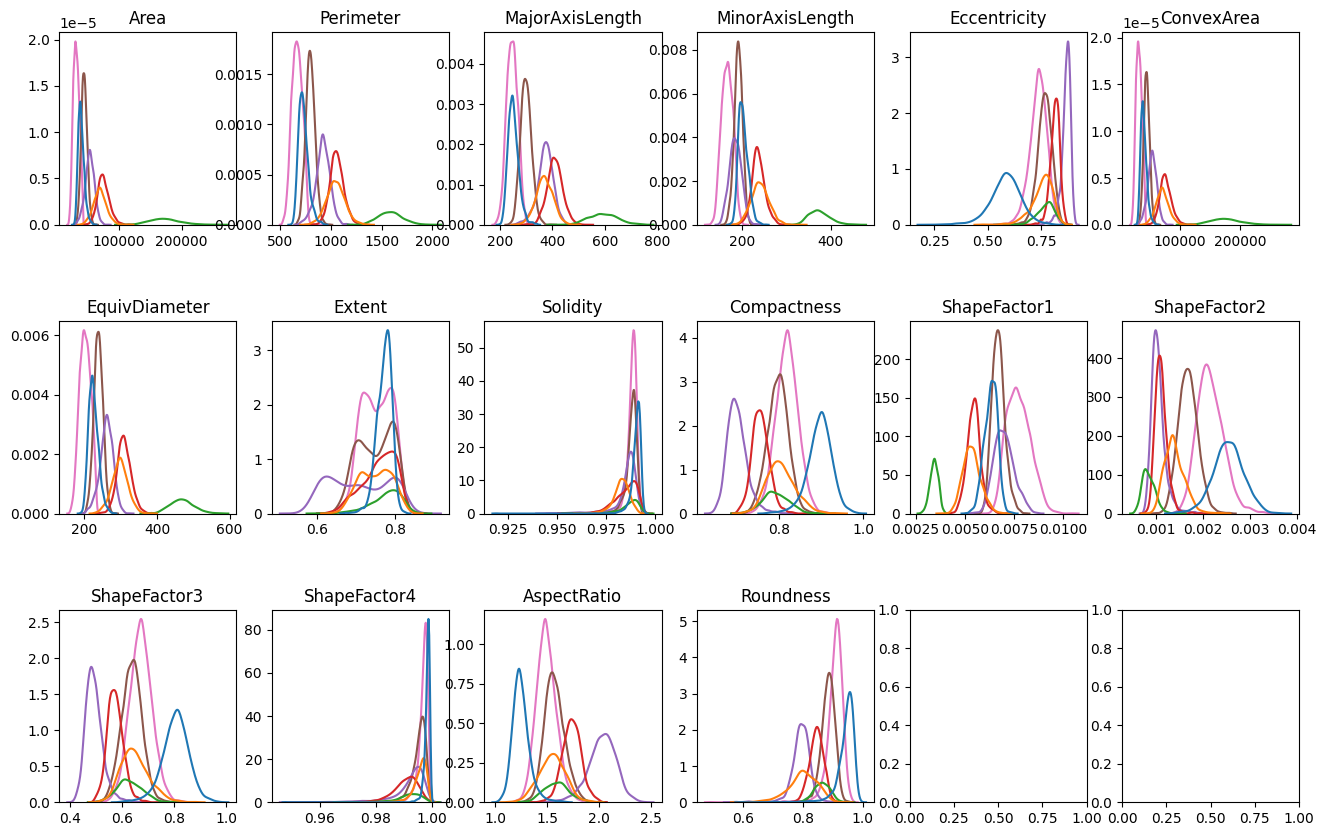

In [10]:
def plot_distributions(
    df,
    y_col: str,
    cols: list[str] =[],
    figsize: tuple = (18, 12),
    max_cols: int=6,
    args: dict = {}):

    if not cols:
        cols = list(df.columns)
        cols.remove(y_col)

    n_rows = int(len(cols)/max_cols) + (len(cols)%max_cols>0)
    n_cols = max_cols

    plt.figure()

    fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize)
    fig.subplots_adjust(hspace=0.5)

    for i, col in enumerate(cols):
        f = i // n_cols
        c = i % n_cols

        sns.kdeplot(df, x=col, hue=y_col, ax=axs[f, c], legend=False)

        axs[f, c].set_title(col)
        axs[f, c].set_xlabel('')
        axs[f, c].set_ylabel('')

    plt.show()

plot_distributions(
    df_raw,
    y_col="Class",
    cols=[ c for c in df_raw.columns if c not in ["Class"] ],
    figsize=(16, 10),
    max_cols = 6)

([<matplotlib.patches.Wedge at 0x7a414ce6db70>,
 [Text(0.751679329714481, 0.8031053388441574, 'SEKER'),
  Text(-0.6870007945063251, 0.8590866710336497, 'BARBUNYA'),
  Text(-1.0822213746170437, -0.1969692776094701, 'BOMBAY'),
  Text(-0.505904905488525, -0.9767600660359979, 'CALI'),
  Text(0.37029123837251354, -1.0358013317159573, 'HOROZ'),
  Text(0.9400104575468422, -0.5712970678224916, 'SIRA'),
  Text(1.092025607090488, -0.1322122288544125, 'DERMASON')],
 [Text(0.4100069071169896, 0.4380574575513585, '26.1%'),
  Text(-0.3747277060943591, 0.46859272965471793, '19.4%'),
  Text(-0.5903025679729329, -0.10743778778698368, '14.9%'),
  Text(-0.2759481302664681, -0.532778217837817, '14.2%'),
  Text(0.2019770391122801, -0.5649825445723403, '12.0%'),
  Text(0.5127329768437321, -0.3116165824486317, '9.7%'),
  Text(0.5956503311402661, -0.0721157611933159, '3.8%')])

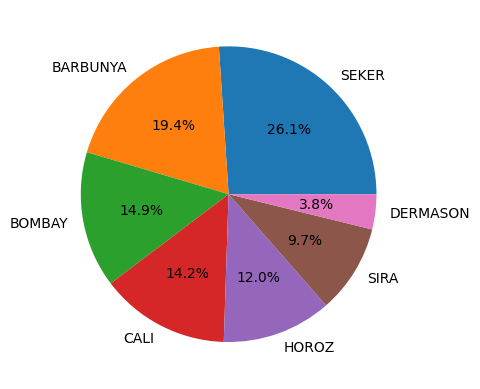

In [11]:
plt.pie(df_raw["Class"].value_counts(), labels=list(df_raw["Class"].unique()), autopct='%1.1f%%' )

## Matriz de correlacion

<Axes: >

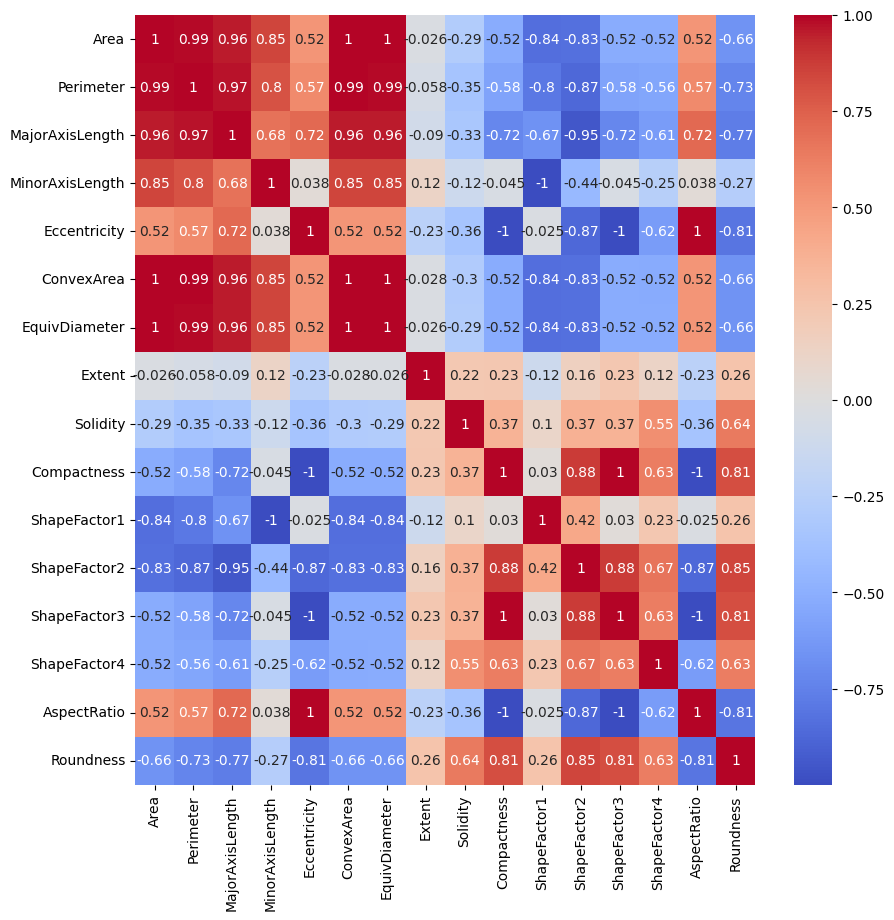

In [12]:
plt.figure(figsize=(10,10))
sns.heatmap(df_raw.drop("Class", axis=1).corr(method="spearman"), annot=True, cmap="coolwarm")

## Split del dataset

In [13]:
y_col = "Class"
x_cols = [c for c in df_raw.columns if c != y_col]

x_train, x_test, y_train, y_test = train_test_split(df_raw[x_cols], df_raw[y_col], test_size=0.2, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((10888, 16), (2723, 16), (10888,), (2723,))

## Normalizacion


In [14]:
def scale_df(train, test):
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(train)
    x_test_scaled = scaler.transform(test)
    return x_train_scaled, x_test_scaled

x_train_scaled, x_test_scaled = scale_df(x_train, x_test)

## Dummies

In [15]:
# y_train_dummy = tf.keras.utils.to_categorical(y_train, num_classes=len(df_raw["ClassEncoded"].unique()))
# y_test_dummy = tf.keras.utils.to_categorical(y_test, num_classes=len(df_raw["ClassEncoded"].unique()))

y_train_dummy = pd.get_dummies(y_train)
y_test_dummy = pd.get_dummies(y_test)

# Modelo


## Optuna

<p> Utilizamos optuna para generar el mejor modelo posible </p>

In [16]:
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

def target_class(trial: optuna.trial.Trial , x_train, x_test, y_train, y_test, batch_size=50, epochs=10):

    num_capas = trial.suggest_int("num_layers", 1, 4)

    model = Sequential()
    for i in range(num_capas):
        num_conexiones = trial.suggest_int(f"n_units_layer_{i}", 4, 200)
        model.add(Dense(num_conexiones, activation="relu"))

    model.add(Dense(7, activation="softmax"))
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[tf.keras.metrics.AUC(curve="ROC")])

    model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, batch_size=batch_size)
    model.summary()
    scores = model.evaluate(x_test, y_test, verbose=0)
    return scores

study = optuna.create_study(directions=["minimize", "maximize"])

study.optimize(
    lambda trial: target_class(
        trial,
        x_train=x_train_scaled,
        x_test=x_test_scaled,
        y_train=y_train_dummy,
        y_test=y_test_dummy
    ),
    n_trials=1
)


[I 2024-07-10 00:04:21,077] A new study created in memory with name: no-name-4852e072-a15a-4ab8-a6f0-93a218b7b2e4


Epoch 1/10
218/218 [==============================] - 14s 50ms/step - loss: 0.4454 - auc: 0.9858 - val_loss: 0.2332 - val_auc: 0.9945
Epoch 2/10
218/218 [==============================] - 11s 50ms/step - loss: 0.2187 - auc: 0.9949 - val_loss: 0.2088 - val_auc: 0.9952
Epoch 3/10
218/218 [==============================] - 11s 50ms/step - loss: 0.2049 - auc: 0.9953 - val_loss: 0.2001 - val_auc: 0.9956
Epoch 4/10
218/218 [==============================] - 11s 50ms/step - loss: 0.2009 - auc: 0.9954 - val_loss: 0.2013 - val_auc: 0.9954
Epoch 5/10
218/218 [==============================] - 10s 46ms/step - loss: 0.1991 - auc: 0.9957 - val_loss: 0.1999 - val_auc: 0.9949
Epoch 6/10
218/218 [==============================] - 11s 49ms/step - loss: 0.1927 - auc: 0.9956 - val_loss: 0.2016 - val_auc: 0.9957
Epoch 7/10
218/218 [==============================] - 11s 49ms/step - loss: 0.1893 - auc: 0.9957 - val_loss: 0.1955 - val_auc: 0.9958
Epoch 8/10
218/218 [==============================] - 11s 50ms

[I 2024-07-10 00:06:14,411] Trial 0 finished with values: [0.18890446424484253, 0.9958925843238831] and parameters: {'num_layers': 2, 'n_units_layer_0': 159, 'n_units_layer_1': 103}. 


## Modelo

In [18]:
def make_model(input_shape, n_classes, num_layers, units_per_layer):
    model = Sequential()

    for i in range(num_layers):
        if i == 0:
            model.add(Dense(units_per_layer[i], activation='relu', input_shape=input_shape))
        else:
            model.add(Dense(units_per_layer[i], activation='relu'))

    model.add(Dense(n_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['AUC'])

    return model


optimal_params = {
    'num_layers': 2,
    'units_per_layer': [159, 103]
}

input_shape = (x_train_scaled.shape[1],)
n_classes = y_train_dummy.shape[1]

model = make_model(input_shape, n_classes, **optimal_params)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 159)               2703      
                                                                 
 dense_5 (Dense)             (None, 103)               16480     
                                                                 
 dense_6 (Dense)             (None, 7)                 728       
                                                                 
Total params: 19911 (77.78 KB)
Trainable params: 19911 (77.78 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Entrenamiento

In [20]:
history = model.fit(x_train_scaled, y_train_dummy, validation_data=(x_test_scaled, y_test_dummy), epochs=10, batch_size=50)

Epoch 1/10
218/218 [==============================] - 15s 68ms/step - loss: 0.1804 - auc_1: 0.9963 - val_loss: 0.1879 - val_auc_1: 0.9956
Epoch 2/10
218/218 [==============================] - 11s 49ms/step - loss: 0.1797 - auc_1: 0.9964 - val_loss: 0.1848 - val_auc_1: 0.9956
Epoch 3/10
218/218 [==============================] - 11s 49ms/step - loss: 0.1814 - auc_1: 0.9961 - val_loss: 0.1935 - val_auc_1: 0.9949
Epoch 4/10
218/218 [==============================] - 11s 49ms/step - loss: 0.1802 - auc_1: 0.9961 - val_loss: 0.1906 - val_auc_1: 0.9950
Epoch 5/10
218/218 [==============================] - 11s 49ms/step - loss: 0.1772 - auc_1: 0.9963 - val_loss: 0.1928 - val_auc_1: 0.9953
Epoch 6/10
218/218 [==============================] - 11s 49ms/step - loss: 0.1774 - auc_1: 0.9964 - val_loss: 0.1921 - val_auc_1: 0.9950
Epoch 7/10
218/218 [==============================] - 10s 46ms/step - loss: 0.1743 - auc_1: 0.9965 - val_loss: 0.1966 - val_auc_1: 0.9946
Epoch 8/10
218/218 [==============

In [23]:
history.history.keys()

dict_keys(['loss', 'auc_1', 'val_loss', 'val_auc_1'])

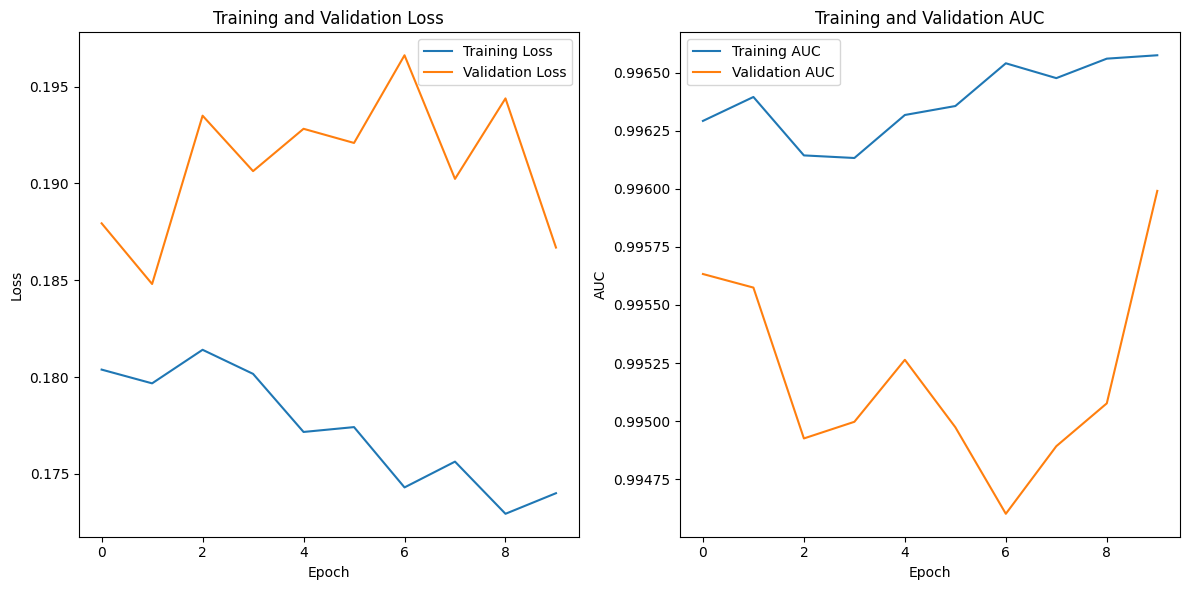

In [30]:
# Obtener métricas de entrenamiento y validación
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_auc = history.history['auc_1']
val_auc = history.history['val_auc_1']

# Crear gráficos de Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Crear gráficos de AUC
plt.subplot(1, 2, 2)
plt.plot(train_auc, label='Training AUC')
plt.plot(val_auc, label='Validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()

# Metricas

86/86 [==============================] - 2s 19ms/step


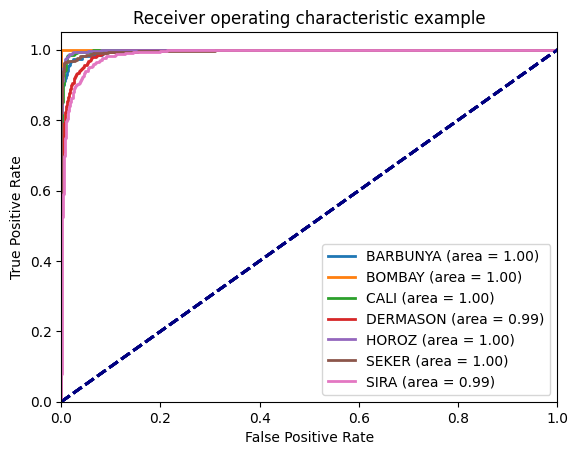

In [36]:
y_pred_keras = model.predict(x_test_scaled)

def plot_roc_auc(classes: list[str], y_pred, y_test):
    plt.figure()
    lw = 2

    fpr = dict()
    tpr = dict()
    roc_auc = dict()


    for i in range(n_classes):

        class_name = classes[i]

        fpr[i], tpr[i], _ = roc_curve(y_test[class_name], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

        plt.plot(
            fpr[i],
            tpr[i],
            lw=lw,
            label="%s (area = %0.2f)" % (class_name,roc_auc[i])
        )
        plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Receiver operating characteristic example")
        plt.legend(loc="lower right")

    plt.show()

plot_roc_auc ( y_test_dummy.columns, y_pred_keras, y_test_dummy)

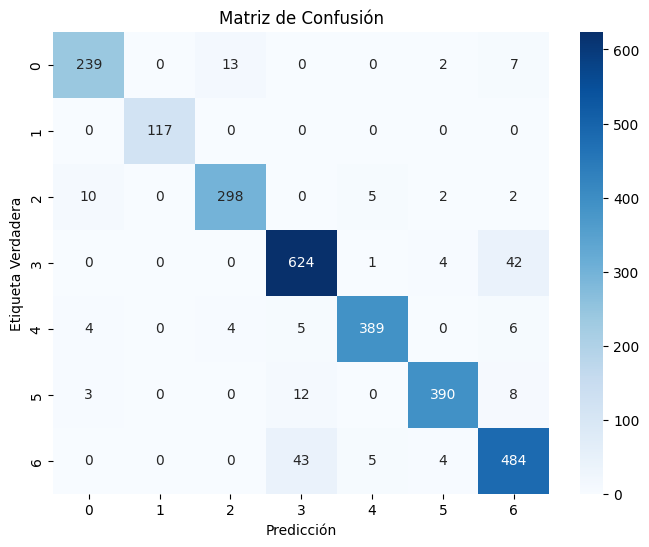

In [37]:
# Convertir las probabilidades en clases (usando argmax para clasificación multiclase)
y_pred = np.argmax(y_pred_keras, axis=1)

cm = confusion_matrix(np.argmax(y_test_dummy, axis=1), y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Verdadera')
plt.show()

# Oversampling

## Oversampling

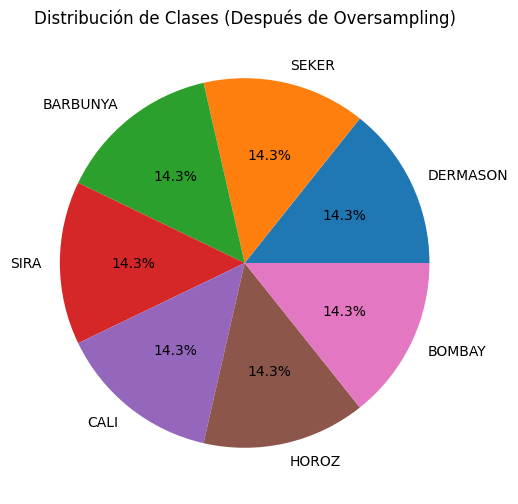

Distribución de clases balanceada:
Counter({'DERMASON': 2875, 'SEKER': 2875, 'BARBUNYA': 2875, 'SIRA': 2875, 'CALI': 2875, 'HOROZ': 2875, 'BOMBAY': 2875})


In [40]:
# Aplicar oversampling solo en el conjunto de entrenamiento para evitar data leakage
oversampler = RandomOverSampler(random_state=42)
x_train_balanced, y_train_balanced = oversampler.fit_resample(x_train, y_train)

# Mostrar la distribución de clases después de aplicar oversampling
plt.figure(figsize=(6, 6))
plt.pie(pd.Series(y_train_balanced).value_counts(), labels=list(pd.Series(y_train_balanced).unique()), autopct='%1.1f%%')
plt.title('Distribución de Clases (Después de Oversampling)')
plt.show()

# Verificar la distribución de clases balanceada
print("Distribución de clases balanceada:")
print(Counter(y_train_balanced))

In [41]:
x_train_balanced_scaled, x_test_scaled = scale_df(x_train_balanced, x_test)
y_train_balanced_dummy = pd.get_dummies(y_train_balanced)
y_test_dummy = pd.get_dummies(y_test)

## Modelo

In [43]:
model_2 = make_model(input_shape=(x_train_balanced_scaled.shape[1],), n_classes=y_train_balanced_dummy.shape[1], **optimal_params)

history_2 = model_2.fit(x_train_balanced_scaled, y_train_balanced_dummy,
                        validation_data=(x_test_scaled, y_test_dummy),
                        epochs=10, batch_size=50)

scores_2 = model_2.evaluate(x_test_scaled, y_test_dummy, verbose=0)
print(f'Loss en el conjunto de prueba (modelo_2): {scores_2[0]}')
print(f'AUC en el conjunto de prueba (modelo_2): {scores_2[1]}')


Epoch 1/10
403/403 [==============================] - 23s 57ms/step - loss: 0.3060 - auc_2: 0.9923 - val_loss: 0.2211 - val_auc_2: 0.9948
Epoch 2/10
403/403 [==============================] - 21s 52ms/step - loss: 0.1756 - auc_2: 0.9965 - val_loss: 0.2004 - val_auc_2: 0.9956
Epoch 3/10
403/403 [==============================] - 18s 45ms/step - loss: 0.1671 - auc_2: 0.9967 - val_loss: 0.2033 - val_auc_2: 0.9959
Epoch 4/10
403/403 [==============================] - 20s 50ms/step - loss: 0.1616 - auc_2: 0.9969 - val_loss: 0.1996 - val_auc_2: 0.9956
Epoch 5/10
403/403 [==============================] - 19s 47ms/step - loss: 0.1547 - auc_2: 0.9972 - val_loss: 0.2036 - val_auc_2: 0.9955
Epoch 6/10
403/403 [==============================] - 19s 48ms/step - loss: 0.1550 - auc_2: 0.9970 - val_loss: 0.2026 - val_auc_2: 0.9955
Epoch 7/10
403/403 [==============================] - 19s 46ms/step - loss: 0.1502 - auc_2: 0.9973 - val_loss: 0.1879 - val_auc_2: 0.9958
Epoch 8/10
403/403 [==============

## Metricas

In [46]:
history_2.history.keys()

dict_keys(['loss', 'auc_2', 'val_loss', 'val_auc_2'])

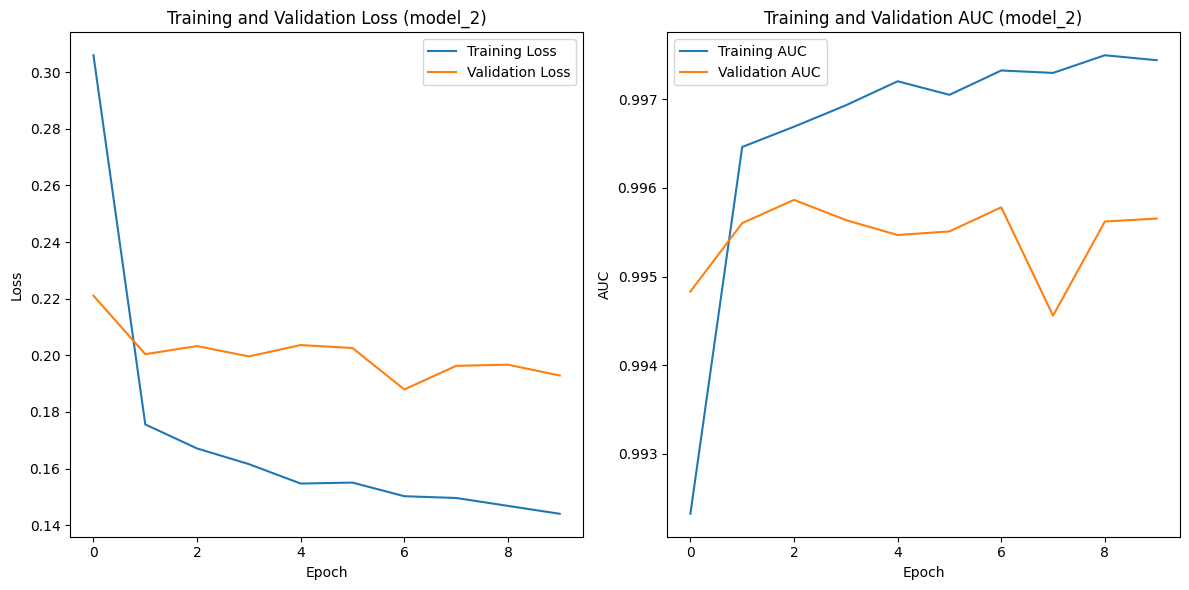

86/86 [==============================] - 0s 5ms/step


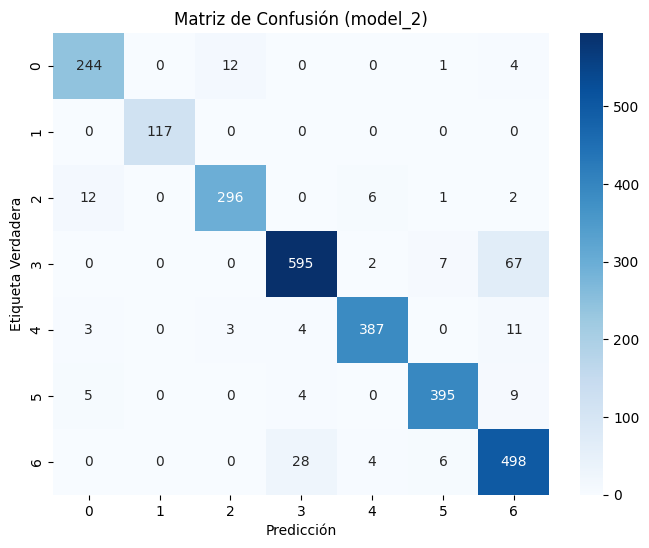

In [48]:
# Obtener métricas de entrenamiento y validación para model_2
train_loss_2 = history_2.history['loss']
val_loss_2 = history_2.history['val_loss']
train_auc_2 = history_2.history['auc_2']
val_auc_2 = history_2.history['val_auc_2']

# Crear gráficos de Loss para model_2
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss_2, label='Training Loss')
plt.plot(val_loss_2, label='Validation Loss')
plt.title('Training and Validation Loss (model_2)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Crear gráficos de AUC para model_2
plt.subplot(1, 2, 2)
plt.plot(train_auc_2, label='Training AUC')
plt.plot(val_auc_2, label='Validation AUC')
plt.title('Training and Validation AUC (model_2)')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()

# Calcular la matriz de confusión para model_2
y_pred_proba_2 = model_2.predict(x_test_scaled)
y_pred_2 = np.argmax(y_pred_proba_2, axis=1)
cm_2 = confusion_matrix(np.argmax(y_test_dummy.values, axis=1), y_pred_2)

# Mostrar la matriz de confusión de model_2
plt.figure(figsize=(8, 6))
sns.heatmap(cm_2, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión (model_2)')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Verdadera')
plt.show()


# Conclusion

El segundo modelo tiene un rendimiento levemente mejor segun los valores del auc